# BM4D Experiment

In [1]:
import os
import time

import bm4d
import numpy as np
import matplotlib.pyplot as plt

from module.utils import calculate_metrics, display_image_in_detail, plot_2d_data, timer_decorator, display_4d_image
from module.datasets import load_4d_dicom, save_4d_dicom

import h5py

from tqdm.notebook import tqdm

# from skimage.metrics import peak_signal_noise_ratio as cal_psnr
# from skimage.metrics import structural_similarity as cal_ssim

In [2]:
from scipy.stats import median_abs_deviation

def mad_estimate(image):
    median = np.median(image)

    # calculate the diff between all pixels and median 
    mad = median_abs_deviation(image)

    # convert MAD into std estimation
    # 0.6745 is constant number for gaussian distribution
    noise_level = mad / 0.6745

    return np.mean(noise_level)



from scipy.ndimage import uniform_filter
# define Anscombe transform
def anscombe(x):
    return 2 * np.sqrt(x + 3 / 8)

# define inverse anscombe transform
def inv_anscombe(y):
    return (y / 2) ** 2 - 3 / 8

# estimate transformed noise std by sliding window
def anscombe_estimate(image, window_size=7):
    # calculate local mean
    local_mean = uniform_filter(image, window_size)
    
    # calculate local variance
    local_var = uniform_filter(image**2, window_size) - local_mean**2
    
    # calcualte average std 
    noise_std = np.sqrt(np.clip(local_var, 0, np.inf)).mean()
    
    return noise_std

## Load dataset

In [3]:
# load noisy data
with h5py.File('./dataset/preprocessed/PT_20p 150_120 OSEM_poiss_0.9.h5', 'r') as f:
    noisy_data = f['dataset'][...]
    restore_info = f['restore_info'][...]
    
print(f"Noisy data...{noisy_data.dtype} (shape:{noisy_data.shape}; range:[{np.min(noisy_data)},{np.max(noisy_data)}]; mean:{np.mean(noisy_data)}); std:{np.std(noisy_data)}")

print(restore_info)


Noisy data...float64 (shape:(24, 71, 192, 192); range:[0.0,1.0]; mean:0.4716438607016555); std:0.02681699286189618
b'{"mean": 201.12048776036573, "std": 1412.4139804758772, "min": -23.34168377224119, "max": 23.05689405684542}'


## Example denoising 

noisy_image: dtype:float64 range(0.377554873657171,0.9920162893073483) mean:0.47126953309616404 std:0.026186367980262484
estimate noise_level
mad:0.02723347784586175 anscombe:0.021619449843950908
denoised_image: dtype:float64 range(0.39787957072257996,0.9413079023361206) mean:0.47060978097341233 std:0.018465848970340037
calculate_metrics running: 0.11480460001621395 second
PSNR: 30.563334559607306; SSIM: 0.5328019659359271; MAE: 1.0056077618390484


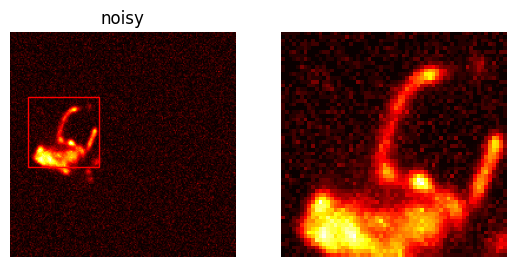

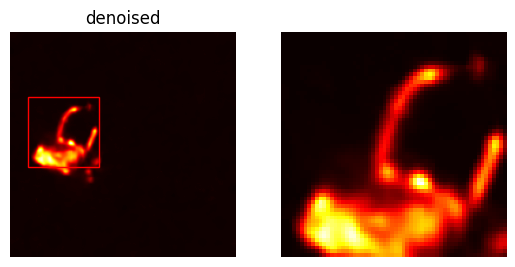

In [4]:
#
noisy_image = noisy_data[time_idx]
print(f"noisy_image: dtype:{noisy_image.dtype} range({np.min(noisy_image)},{np.max(noisy_image)}) mean:{np.mean(noisy_image)} std:{np.std(noisy_image)}")


# estimate noise level 
noise_level = mad_estimate(noisy_image)

noise_level2 = anscombe_estimate(anscombe(noisy_image))

print(f"estimate noise_level\nmad:{noise_level} anscombe:{noise_level2}")


# process denoising using anscombe for estimate since it better
denoised_image = bm4d.bm4d(noisy_image, noise_level2)
print(f"denoised_image: dtype:{denoised_image.dtype} range({np.min(denoised_image)},{np.max(denoised_image)}) mean:{np.mean(denoised_image)} std:{np.std(denoised_image)}")


# calculate PSNR, SSIM and MAE
data_range_denoised = np.max(denoised_image) - np.min(denoised_image)
data_range_noisy = np.max(noisy_image) - np.min(noisy_image)
data_range = max(data_range_denoised, data_range_noisy)
psnr_values, ssim_values, mae_values = calculate_metrics(denoised_image, noisy_image, data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.sum(mae_values)}")


# show result
time_idx = 11
depth_idx = 38
zoom_coordinates = (55, 15, 60, 60)
display_image_in_detail(noisy_image[depth_idx], title='noisy')
display_image_in_detail(denoised_image[depth_idx], title='denoised')

## Process denoising

In [5]:
# denoised 
@timer_decorator
def process(noisy_data, noise_level):
    denoised_data = np.zeros_like(noisy_data)
    with tqdm(total=noisy_data.shape[0]) as pbar:
        for i in range(noisy_data.shape[0]):
            sub_image = noisy_data[i, :, :, :]
            noise_level = anscombe_estimate(anscombe(sub_image))
            denoised_sub_image = bm4d.bm4d(sub_image, noise_level)
            denoised_data[i, :, :, :] = denoised_sub_image
            pbar.update(1)
    return denoised_data


denoised_data = process(noisy_data, noise_level)
            
print(f"denoised_data: dtype:{denoised_data.dtype} range({np.min(denoised_data)},{np.max(denoised_data)}) mean:{np.mean(denoised_data)} std:{np.std(denoised_data)}")

  0%|          | 0/24 [00:00<?, ?it/s]

process running: 1206.3762453000236 second
denoised_data: dtype:float64 range(-0.007028264459222555,0.9873039722442627) mean:0.471021119402097 std:0.019216502740415104


## Evaluation

Calculate PSNR, SSIM

In [6]:
# calcualte PSNR, SSIM between denoised data and noisy data
data_range_noisy = np.max(noisy_data) - np.min(noisy_data)
data_range_denoised = np.max(denoised_data) - np.min(denoised_data)
data_range = max(data_range_noisy, data_range_denoised)
print(f"data range: {data_range}")

#
psnr_values, ssim_values, mae_values = calculate_metrics(denoised_data, noisy_data, data_range=data_range)
print(f"PSNR: {np.nanmean(psnr_values)}; SSIM: {np.nanmean(ssim_values)}; MAE: {np.mean(mae_values)}")


data range: 1.0
calculate_metrics running: 2.8501333000021987 second
PSNR: 34.757758727188104; SSIM: 0.7407721004442784; MAE: 0.014239788350422134


## Save denormalized denoised image into int16 DICOM file

In [7]:
# denormalzied denoised data
mean_val = 201.12048776036573
std_val = 1412.4139804758772
max_val = 23.05689405684542
min_val = -23.34168377224119


denormalized_denoised_data = denoised_data * (max_val - min_val) + min_val
denormalized_denoised_data = denormalized_denoised_data * std_val + mean_val

denormalized_denoised_data = np.clip(denormalized_denoised_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)


print(f"denormalized_denoised_data: dtype:{denormalized_denoised_data.dtype} range({np.min(denormalized_denoised_data)},{np.max(denormalized_denoised_data)}) mean:{np.mean(denormalized_denoised_data)} std:{np.std(denormalized_denoised_data)}")

display_4d_image(denormalized_denoised_data)

denormalized_denoised_data: dtype:int16 range(-32768,31934) mean:-1898.6216806203795 std:1259.2259536884205


interactive(children=(IntSlider(value=0, description='Time', max=23), IntSlider(value=0, description='Slice', …

In [ ]:
origin_dicom_folder = './dataset/TracPETperf-D2-PhantomExperiments2/PT_20p 150_120 OSEM'

output_folder = './dataset/denoised/BM4D/PT_20p 150_120 OSEM_poiss_0.9'

save_4d_dicom(origin_dicom_folder, denormalized_denoised_data, output_folder)